# Sentinel Data Generator - Log Analysis

This notebook analyzes the demo security data generated by the Sentinel Data Generator project.
It runs on the **Microsoft Sentinel Data Lake** using the `MicrosoftSentinelProvider` class
with Apache Spark and `matplotlib` for visualizations.

**Tables Analyzed:**
- `SecurityEventDemo_CL` — Windows Security Events
- `CommonSecurityLog` — CEF/Syslog from security appliances
- `SigninLogDemo_CL` — Azure AD/Entra ID Sign-in Logs
- `SyslogDemo_CL` — Linux Syslog Events

**Requirements:**
- Microsoft Sentinel extension for VS Code
- Sentinel Data Lake onboarded
- Select a Microsoft Sentinel runtime (Small/Medium/Large) when prompted

> Based on [Microsoft Sentinel Data Lake notebook documentation](https://learn.microsoft.com/en-us/azure/sentinel/datalake/notebooks)

## 1. Setup and Connection

Initialize the `MicrosoftSentinelProvider` using the Spark session provided by the Sentinel runtime.

In [6]:
import matplotlib.pyplot as plt
from sentinel_lake.providers import MicrosoftSentinelProvider
from pyspark.sql.functions import (
    col, count, countDistinct, when, desc, asc, lit, lower, sum as spark_sum
)

data_provider = MicrosoftSentinelProvider(spark)
print("MicrosoftSentinelProvider initialized")

StatementMeta(MSGMedium, 2, 7, Finished, Available, Finished)

MicrosoftSentinelProvider initialized


In [7]:
# Replace with your workspace name
WORKSPACE_NAME = "SDLWS"

# List available databases to verify connectivity
databases = data_provider.list_databases()
print("Available databases/workspaces:")
for db in databases:
    print(f"  - {db}")

StatementMeta(MSGMedium, 2, 8, Finished, Available, Finished)

Available databases/workspaces:
  - System Tables
  - SDLWS


## 2. Load All Tables

Read the four demo tables from the data lake into Spark DataFrames.

In [8]:
# Load all four tables
df_security_events = data_provider.read_table("SecurityEventDemo_CL", WORKSPACE_NAME)
df_common_security = data_provider.read_table("CommonSecurityLog", WORKSPACE_NAME)
df_signin_logs = data_provider.read_table("SigninLogDemo_CL", WORKSPACE_NAME)
df_syslog = data_provider.read_table("SyslogDemo_CL", WORKSPACE_NAME)

# Get row counts
counts = {
    "SecurityEventDemo_CL": df_security_events.count(),
    "CommonSecurityLog": df_common_security.count(),
    "SigninLogDemo_CL": df_signin_logs.count(),
    "SyslogDemo_CL": df_syslog.count()
}

total = sum(counts.values())
print(f"Total events loaded: {total:,}")
for table, cnt in counts.items():
    print(f"  {table}: {cnt:,}")

StatementMeta(MSGMedium, 2, 9, Finished, Available, Finished)

{"Level": "INFO", "TraceId": "b6679287-c892-48f0-9c86-5248ed448918", "Message": "Loading table: SecurityEventDemo_CL"}
{"Level": "INFO", "TraceId": "b6679287-c892-48f0-9c86-5248ed448918", "Message": "Successfully loaded table SecurityEventDemo_CL"}
{"Level": "INFO", "TraceId": "b6679287-c892-48f0-9c86-5248ed448918", "Message": "Loading table: CommonSecurityLog"}
{"Level": "INFO", "TraceId": "b6679287-c892-48f0-9c86-5248ed448918", "Message": "Successfully loaded table CommonSecurityLog"}
{"Level": "INFO", "TraceId": "b6679287-c892-48f0-9c86-5248ed448918", "Message": "Loading table: SigninLogDemo_CL"}
{"Level": "INFO", "TraceId": "b6679287-c892-48f0-9c86-5248ed448918", "Message": "Successfully loaded table SigninLogDemo_CL"}
{"Level": "INFO", "TraceId": "b6679287-c892-48f0-9c86-5248ed448918", "Message": "Loading table: SyslogDemo_CL"}
{"Level": "INFO", "TraceId": "b6679287-c892-48f0-9c86-5248ed448918", "Message": "Successfully loaded table SyslogDemo_CL"}
Total events loaded: 3,031
  Sec

StatementMeta(MSGMedium, 2, 10, Finished, Available, Finished)

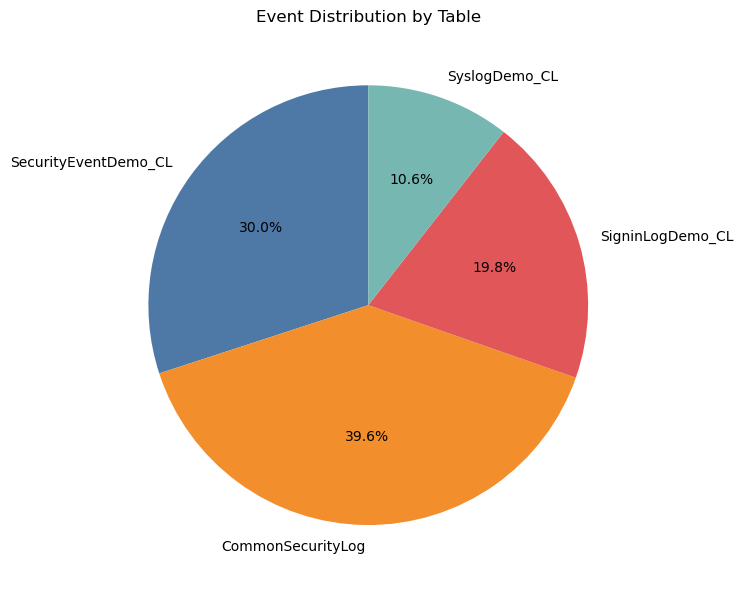

In [9]:
# Visualize event distribution across tables
fig, ax = plt.subplots(figsize=(8, 6))
ax.pie(
    counts.values(),
    labels=counts.keys(),
    autopct="%1.1f%%",
    startangle=90,
    colors=["#4e79a7", "#f28e2b", "#e15759", "#76b7b2"]
)
ax.set_title("Event Distribution by Table")
plt.tight_layout()
plt.show()

## 3. SecurityEventDemo_CL Analysis

Windows Security Events including failed/successful logons, privilege escalation, and account management.

In [10]:
# Security events by EventID
security_by_event = (
    df_security_events
    .groupBy("EventID", "Activity")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
)

security_by_event.show(truncate=False)

StatementMeta(MSGMedium, 2, 11, Finished, Available, Finished)

+-------+------------------------------------------------+-----+
|EventID|Activity                                        |Count|
+-------+------------------------------------------------+-----+
|4625   |4625 - An account failed to log on.             |504  |
|4624   |4624 - An account was successfully logged on.   |240  |
|4720   |4720 - A user account was created.              |88   |
|4672   |4672 - Special privileges assigned to new logon.|78   |
+-------+------------------------------------------------+-----+



StatementMeta(MSGMedium, 2, 12, Finished, Available, Finished)

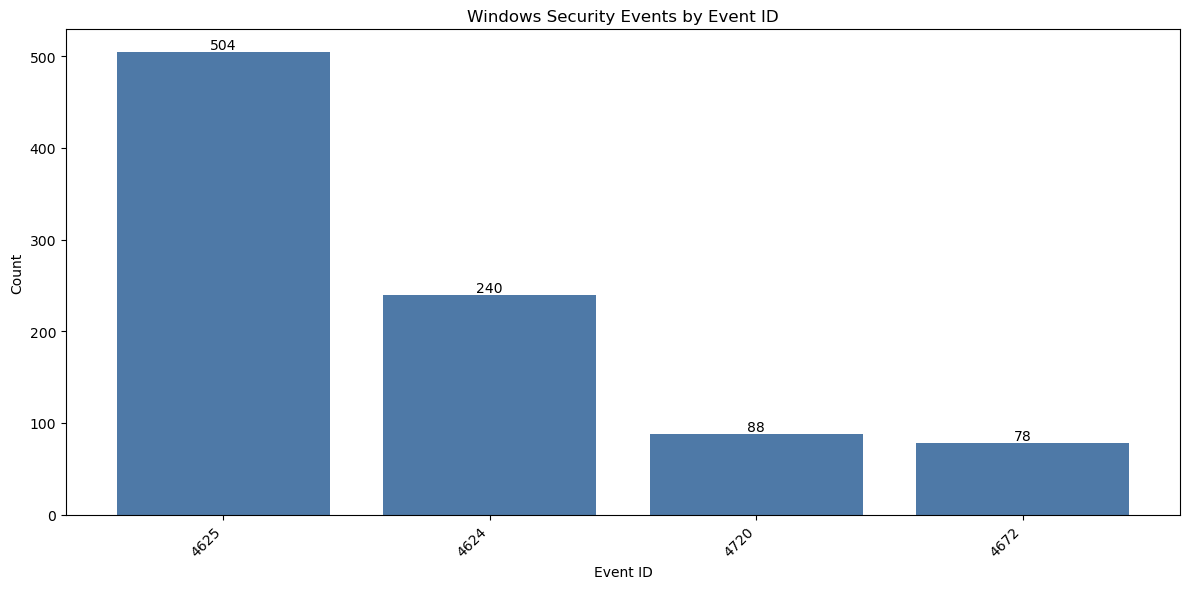

In [11]:
# Visualize security events by EventID
pd_security = security_by_event.toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
bars = ax.bar(pd_security["EventID"].astype(str), pd_security["Count"], color="#4e79a7")
ax.bar_label(bars)
ax.set_xlabel("Event ID")
ax.set_ylabel("Count")
ax.set_title("Windows Security Events by Event ID")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [12]:
# Failed logins analysis — potential brute force detection (EventID 4625)
failed_logins = (
    df_security_events
    .filter(col("EventID") == 4625)
    .groupBy("IpAddress", "Account", "Computer")
    .agg(count("*").alias("FailedAttempts"))
    .filter(col("FailedAttempts") >= 5)
    .orderBy(desc("FailedAttempts"))
    .limit(20)
)

print("Potential Brute Force Sources (5+ failed logins):")
failed_logins.show(truncate=False)

StatementMeta(MSGMedium, 2, 13, Finished, Available, Finished)

Potential Brute Force Sources (5+ failed logins):
+------------+-------+----------------+--------------+
|IpAddress   |Account|Computer        |FailedAttempts|
+------------+-------+----------------+--------------+
|203.0.113.50|admin  |DC01.contoso.com|504           |
+------------+-------+----------------+--------------+



StatementMeta(MSGMedium, 2, 14, Finished, Available, Finished)

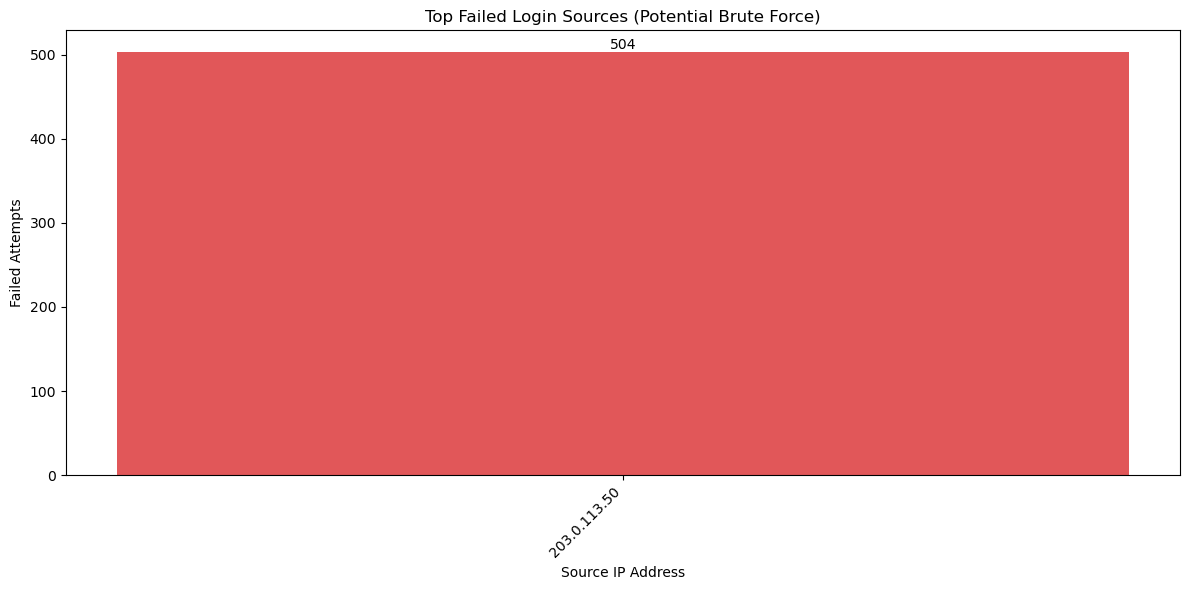

In [13]:
# Visualize top failed login sources
pd_failed = failed_logins.toPandas()

if not pd_failed.empty:
    fig, ax = plt.subplots(figsize=(12, 6))
    top10 = pd_failed.head(10)
    bars = ax.bar(top10["IpAddress"], top10["FailedAttempts"], color="#e15759")
    ax.bar_label(bars)
    ax.set_xlabel("Source IP Address")
    ax.set_ylabel("Failed Attempts")
    ax.set_title("Top Failed Login Sources (Potential Brute Force)")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()
else:
    print("No brute force sources found.")

## 4. CommonSecurityLog Analysis

CEF events from security appliances including firewall, IDS, and threat intelligence.

In [14]:
# Events by vendor and event class
cef_by_vendor = (
    df_common_security
    .groupBy("DeviceVendor", "DeviceEventClassID")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
    .limit(20)
)

cef_by_vendor.show(truncate=False)

StatementMeta(MSGMedium, 2, 15, Finished, Available, Finished)

+------------------+------------------+-----+
|DeviceVendor      |DeviceEventClassID|Count|
+------------------+------------------+-----+
|Palo Alto Networks|intrusion:detected|171  |
|Palo Alto Networks|threat:match      |152  |
|Palo Alto Networks|traffic:allow     |125  |
|Palo Alto Networks|malware:detected  |115  |
|Palo Alto Networks|traffic:deny      |113  |
|Palo Alto Networks|web:access        |106  |
|Palo Alto Networks|vpn:connection    |100  |
|Check Point       |intrusion:detected|64   |
|Cisco             |intrusion:detected|48   |
|Fortinet          |intrusion:detected|44   |
|Zscaler           |threat:match      |36   |
|Cisco             |threat:match      |35   |
|Zscaler           |intrusion:detected|34   |
|Check Point       |threat:match      |31   |
|Fortinet          |threat:match      |26   |
|Test              |test              |1    |
+------------------+------------------+-----+



StatementMeta(MSGMedium, 2, 16, Finished, Available, Finished)

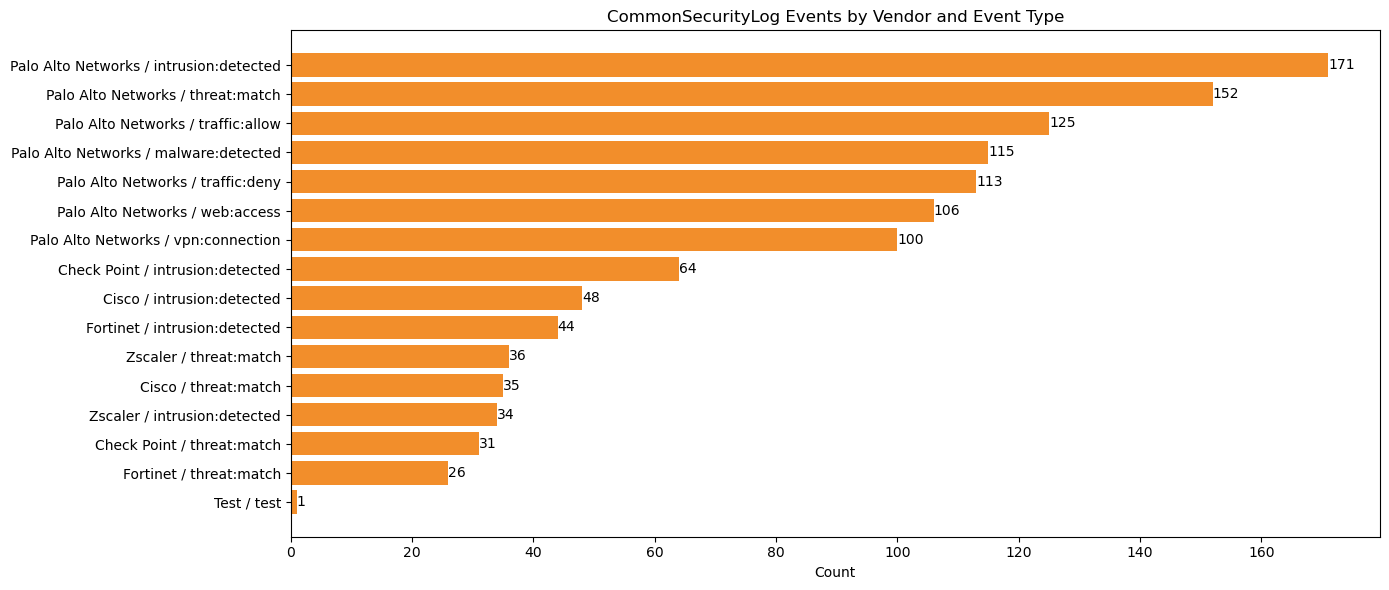

In [15]:
# Visualize CEF events by vendor
pd_cef = cef_by_vendor.toPandas()

fig, ax = plt.subplots(figsize=(14, 6))
labels = pd_cef["DeviceVendor"] + " / " + pd_cef["DeviceEventClassID"]
bars = ax.barh(labels, pd_cef["Count"], color="#f28e2b")
ax.bar_label(bars)
ax.set_xlabel("Count")
ax.set_title("CommonSecurityLog Events by Vendor and Event Type")
ax.invert_yaxis()
plt.tight_layout()
plt.show()

In [16]:
# Threat intelligence and intrusion detections
threat_event_types = ["threat:match", "intrusion:detected", "malware:detected"]

threats = (
    df_common_security
    .filter(col("DeviceEventClassID").isin(threat_event_types))
    .groupBy("DeviceVendor", "DeviceEventClassID", "SourceIP")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
    .limit(15)
)

print("Security Threats Detected:")
threats.show(truncate=False)

StatementMeta(MSGMedium, 2, 17, Finished, Available, Finished)

Security Threats Detected:
+------------------+------------------+-------------+-----+
|DeviceVendor      |DeviceEventClassID|SourceIP     |Count|
+------------------+------------------+-------------+-----+
|Palo Alto Networks|intrusion:detected|198.51.100.11|28   |
|Palo Alto Networks|threat:match      |198.51.100.10|24   |
|Palo Alto Networks|intrusion:detected|203.0.113.51 |24   |
|Palo Alto Networks|intrusion:detected|198.51.100.12|19   |
|Palo Alto Networks|threat:match      |198.51.100.11|19   |
|Palo Alto Networks|threat:match      |203.0.113.52 |18   |
|Palo Alto Networks|intrusion:detected|198.51.100.10|18   |
|Palo Alto Networks|threat:match      |198.51.100.12|18   |
|Palo Alto Networks|threat:match      |203.0.113.51 |18   |
|Palo Alto Networks|malware:detected  |198.51.100.12|17   |
|Palo Alto Networks|malware:detected  |198.51.100.11|16   |
|Palo Alto Networks|intrusion:detected|203.0.113.50 |16   |
|Palo Alto Networks|intrusion:detected|203.0.113.52 |16   |
|Palo Alto Ne

In [17]:
# Firewall denies by source IP
firewall_denies = (
    df_common_security
    .filter(col("DeviceEventClassID") == "traffic:deny")
    .groupBy("SourceIP", "DestinationIP")
    .agg(count("*").alias("DenyCount"))
    .filter(col("DenyCount") >= 5)
    .orderBy(desc("DenyCount"))
    .limit(15)
)

print("Firewall Blocks (5+ denies):")
firewall_denies.show(truncate=False)

StatementMeta(MSGMedium, 2, 18, Finished, Available, Finished)

Firewall Blocks (5+ denies):
+--------+-------------+---------+
|SourceIP|DestinationIP|DenyCount|
+--------+-------------+---------+
+--------+-------------+---------+



## 5. SigninLogDemo_CL Analysis

Azure AD/Entra ID sign-in events including brute force and credential stuffing attacks.

In [18]:
# Sign-in results overview
signin_results = (
    df_signin_logs
    .groupBy("ResultType", "ResultDescription")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
)

signin_results.show(truncate=False)

StatementMeta(MSGMedium, 2, 19, Finished, Available, Finished)

+----------+------------------------------------+-----+
|ResultType|ResultDescription                   |Count|
+----------+------------------------------------+-----+
|50126     |Invalid username or password        |318  |
|0         |Success                             |185  |
|50034     |User account not found              |50   |
|50053     |Account is locked                   |18   |
|50074     |Strong authentication is required   |13   |
|50055     |Password is expired                 |9    |
|53003     |Access blocked by Conditional Access|7    |
+----------+------------------------------------+-----+



StatementMeta(MSGMedium, 2, 20, Finished, Available, Finished)

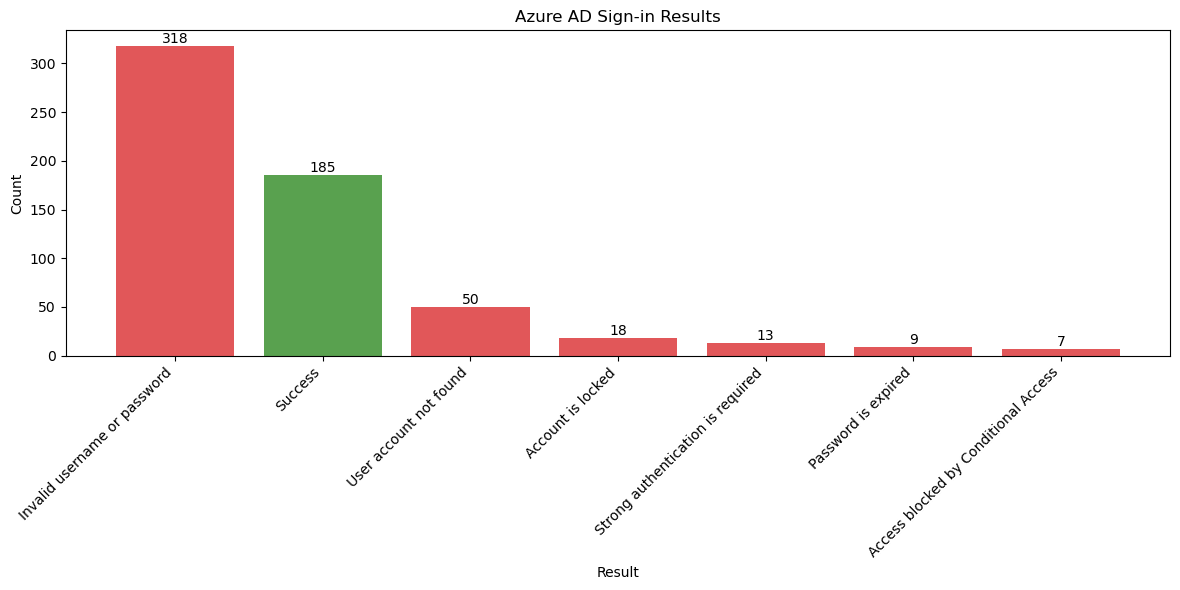

In [19]:
# Visualize sign-in results
pd_signin = signin_results.toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
colors = ["#59a14f" if rt == "0" else "#e15759" for rt in pd_signin["ResultType"]]
bars = ax.bar(pd_signin["ResultDescription"], pd_signin["Count"], color=colors)
ax.bar_label(bars)
ax.set_xlabel("Result")
ax.set_ylabel("Count")
ax.set_title("Azure AD Sign-in Results")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [20]:
# Risky sign-ins
risky_signins = (
    df_signin_logs
    .filter(col("RiskLevelDuringSignIn").isin(["medium", "high"]))
    .groupBy("UserPrincipalName", "IPAddress", "Location", "RiskLevelDuringSignIn")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
    .limit(15)
)

print("Risky Sign-ins Detected:")
risky_signins.show(truncate=False)

StatementMeta(MSGMedium, 2, 21, Finished, Available, Finished)

Risky Sign-ins Detected:
+-----------------------+--------------+-------------+---------------------+-----+
|UserPrincipalName      |IPAddress     |Location     |RiskLevelDuringSignIn|Count|
+-----------------------+--------------+-------------+---------------------+-----+
|admin@contoso.com      |192.0.2.235   |Tehran, IR   |high                 |2    |
|jane.smith@contoso.com |192.0.2.185   |Moscow, RU   |high                 |2    |
|guest_user@external.com|218.71.223.3  |Toronto, CA  |high                 |1    |
|jane.smith@contoso.com |203.0.113.160 |Tehran, IR   |high                 |1    |
|jane.smith@contoso.com |139.117.215.32|Berlin, DE   |medium               |1    |
|admin@contoso.com      |203.0.113.177 |Tehran, IR   |medium               |1    |
|helpdesk@contoso.com   |192.0.2.226   |Pyongyang, KP|high                 |1    |
|guest_user@external.com|203.0.113.143 |Pyongyang, KP|high                 |1    |
|admin@contoso.com      |135.253.40.21 |Sydney, AU   |medium  

In [21]:
# Sign-ins by location — success vs failure
signin_by_location = (
    df_signin_logs
    .groupBy("Location")
    .agg(
        count("*").alias("Total"),
        count(when(col("ResultType") == "0", True)).alias("Success"),
        count(when(col("ResultType") != "0", True)).alias("Failed")
    )
    .orderBy(desc("Total"))
)

signin_by_location.show(truncate=False)

StatementMeta(MSGMedium, 2, 22, Finished, Available, Finished)

+-----------------+-----+-------+------+
|Location         |Total|Success|Failed|
+-----------------+-----+-------+------+
|Moscow, RU       |73   |26     |47    |
|Tehran, IR       |72   |34     |38    |
|Beijing, CN      |71   |33     |38    |
|Bangalore, IN    |71   |27     |44    |
|São Paulo, BR    |57   |26     |31    |
|Pyongyang, KP    |55   |28     |27    |
|Seattle, US      |30   |0      |30    |
|San Francisco, US|29   |2      |27    |
|Toronto, CA      |26   |2      |24    |
|London, GB       |25   |2      |23    |
|New York, US     |24   |1      |23    |
|Tokyo, JP        |23   |1      |22    |
|Berlin, DE       |22   |0      |22    |
|Sydney, AU       |22   |3      |19    |
+-----------------+-----+-------+------+



StatementMeta(MSGMedium, 2, 23, Finished, Available, Finished)

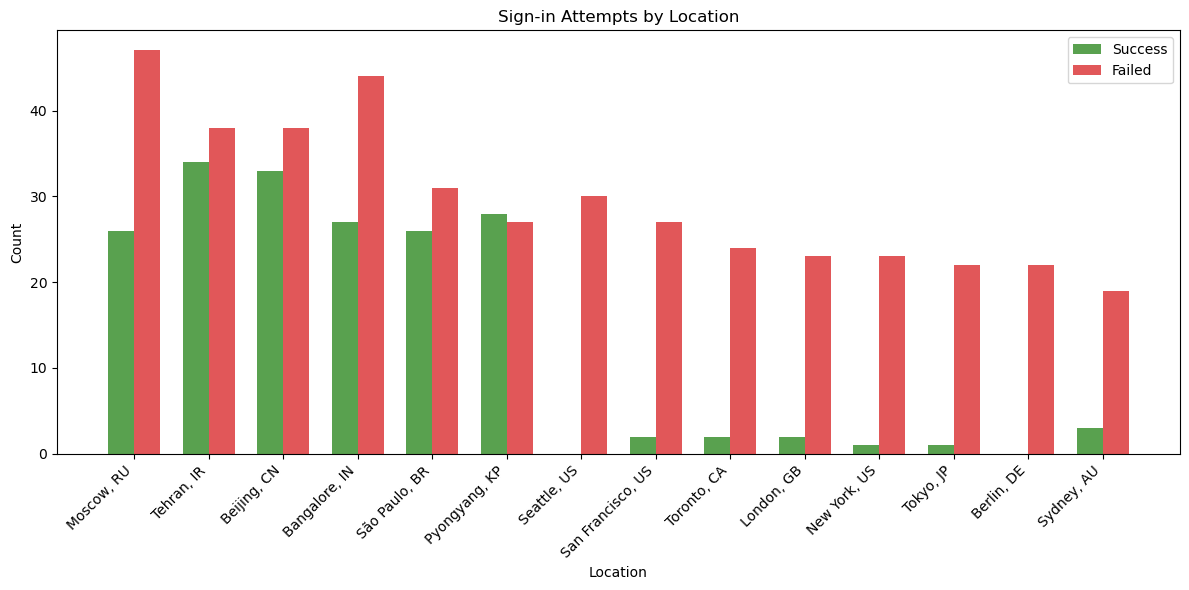

In [22]:
# Visualize sign-ins by location
pd_location = signin_by_location.toPandas()

fig, ax = plt.subplots(figsize=(12, 6))
x = range(len(pd_location))
width = 0.35
ax.bar([i - width/2 for i in x], pd_location["Success"], width, label="Success", color="#59a14f")
ax.bar([i + width/2 for i in x], pd_location["Failed"], width, label="Failed", color="#e15759")
ax.set_xlabel("Location")
ax.set_ylabel("Count")
ax.set_title("Sign-in Attempts by Location")
ax.set_xticks(x)
ax.set_xticklabels(pd_location["Location"], rotation=45, ha="right")
ax.legend()
plt.tight_layout()
plt.show()

## 6. SyslogDemo_CL Analysis

Linux syslog events including SSH authentication, sudo abuse, and service failures.

In [23]:
# Syslog by facility and severity
syslog_overview = (
    df_syslog
    .groupBy("Facility", "SeverityLevel")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
)

syslog_overview.show(truncate=False)

StatementMeta(MSGMedium, 2, 24, Finished, Available, Finished)

+--------+-------------+-----+
|Facility|SeverityLevel|Count|
+--------+-------------+-----+
|auth    |warning      |126  |
|authpriv|info         |100  |
|auth    |err          |34   |
|daemon  |err          |31   |
|daemon  |crit         |29   |
+--------+-------------+-----+



StatementMeta(MSGMedium, 2, 25, Finished, Available, Finished)

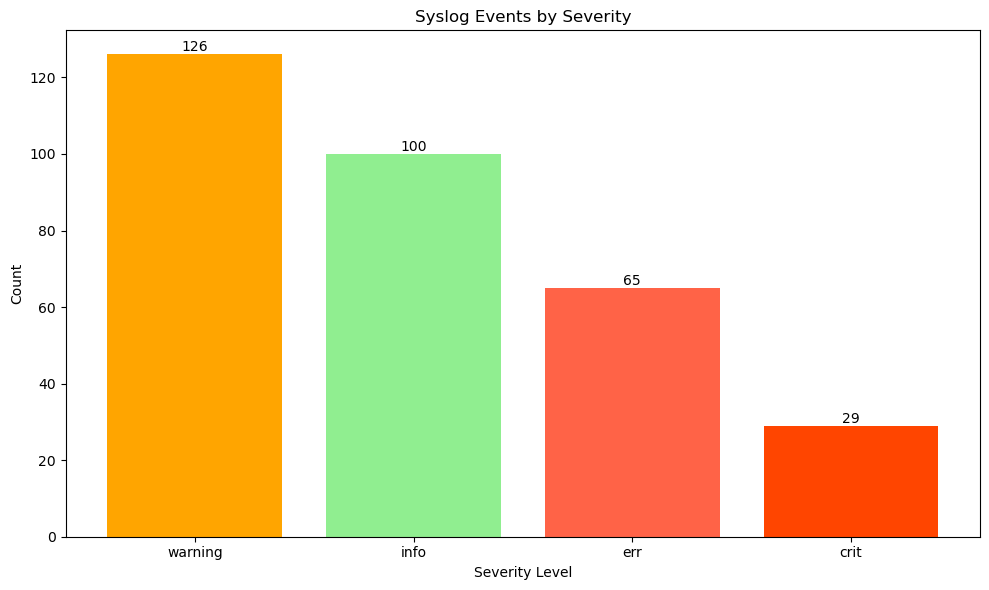

In [24]:
# Visualize syslog severity distribution
pd_syslog = syslog_overview.toPandas()
syslog_by_severity = pd_syslog.groupby("SeverityLevel")["Count"].sum().sort_values(ascending=False)

severity_colors = {
    "emerg": "#8B0000", "alert": "#FF0000", "crit": "#FF4500",
    "err": "#FF6347", "warning": "#FFA500", "notice": "#FFD700",
    "info": "#90EE90", "debug": "#ADD8E6"
}
colors = [severity_colors.get(s, "#CCCCCC") for s in syslog_by_severity.index]

fig, ax = plt.subplots(figsize=(10, 6))
bars = ax.bar(syslog_by_severity.index, syslog_by_severity.values, color=colors)
ax.bar_label(bars)
ax.set_xlabel("Severity Level")
ax.set_ylabel("Count")
ax.set_title("Syslog Events by Severity")
plt.tight_layout()
plt.show()

In [25]:
# SSH authentication failures
ssh_failures = (
    df_syslog
    .filter(
        (col("ProcessName") == "sshd") &
        (col("SyslogMessage").contains("Failed"))
    )
    .groupBy("Computer", "HostIP")
    .agg(count("*").alias("FailedAttempts"))
    .filter(col("FailedAttempts") >= 3)
    .orderBy(desc("FailedAttempts"))
    .limit(15)
)

print("SSH Brute Force Targets (3+ failures):")
ssh_failures.show(truncate=False)

StatementMeta(MSGMedium, 2, 26, Finished, Available, Finished)

SSH Brute Force Targets (3+ failures):
+---------------------------+---------+--------------+
|Computer                   |HostIP   |FailedAttempts|
+---------------------------+---------+--------------+
|k8s-master.contoso.local   |10.1.8.10|10            |
|jump-server.contoso.local  |10.1.7.10|9             |
|mail-server.contoso.local  |10.1.4.10|9             |
|app-server-01.contoso.local|10.1.3.10|8             |
|db-replica.contoso.local   |10.1.2.11|7             |
|proxy-server.contoso.local |10.1.6.10|7             |
|web-server-01.contoso.local|10.1.1.10|7             |
|k8s-worker-01.contoso.local|10.1.8.11|6             |
|dns-server.contoso.local   |10.1.5.10|6             |
|web-server-02.contoso.local|10.1.1.11|5             |
|db-primary.contoso.local   |10.1.2.10|4             |
|app-server-02.contoso.local|10.1.3.11|3             |
+---------------------------+---------+--------------+



In [26]:
# Service failures
service_failures = (
    df_syslog
    .filter(
        (col("Facility") == "daemon") &
        (col("SeverityLevel").isin(["err", "crit"]))
    )
    .groupBy("Computer", "ProcessName", "SeverityLevel")
    .agg(count("*").alias("Count"))
    .orderBy(desc("Count"))
    .limit(15)
)

print("Service Failures:")
service_failures.show(truncate=False)

StatementMeta(MSGMedium, 2, 27, Finished, Available, Finished)

Service Failures:
+---------------------------+-----------+-------------+-----+
|Computer                   |ProcessName|SeverityLevel|Count|
+---------------------------+-----------+-------------+-----+
|k8s-worker-01.contoso.local|systemd    |crit         |6    |
|db-primary.contoso.local   |systemd    |err          |5    |
|k8s-master.contoso.local   |systemd    |err          |5    |
|db-primary.contoso.local   |systemd    |crit         |4    |
|proxy-server.contoso.local |systemd    |crit         |4    |
|web-server-01.contoso.local|systemd    |err          |4    |
|web-server-02.contoso.local|systemd    |crit         |4    |
|jump-server.contoso.local  |systemd    |crit         |3    |
|db-replica.contoso.local   |systemd    |crit         |3    |
|mail-server.contoso.local  |systemd    |err          |3    |
|k8s-worker-01.contoso.local|systemd    |err          |3    |
|app-server-01.contoso.local|systemd    |err          |2    |
|proxy-server.contoso.local |systemd    |err        

## 7. Security Summary Dashboard

StatementMeta(MSGMedium, 2, 28, Finished, Available, Finished)

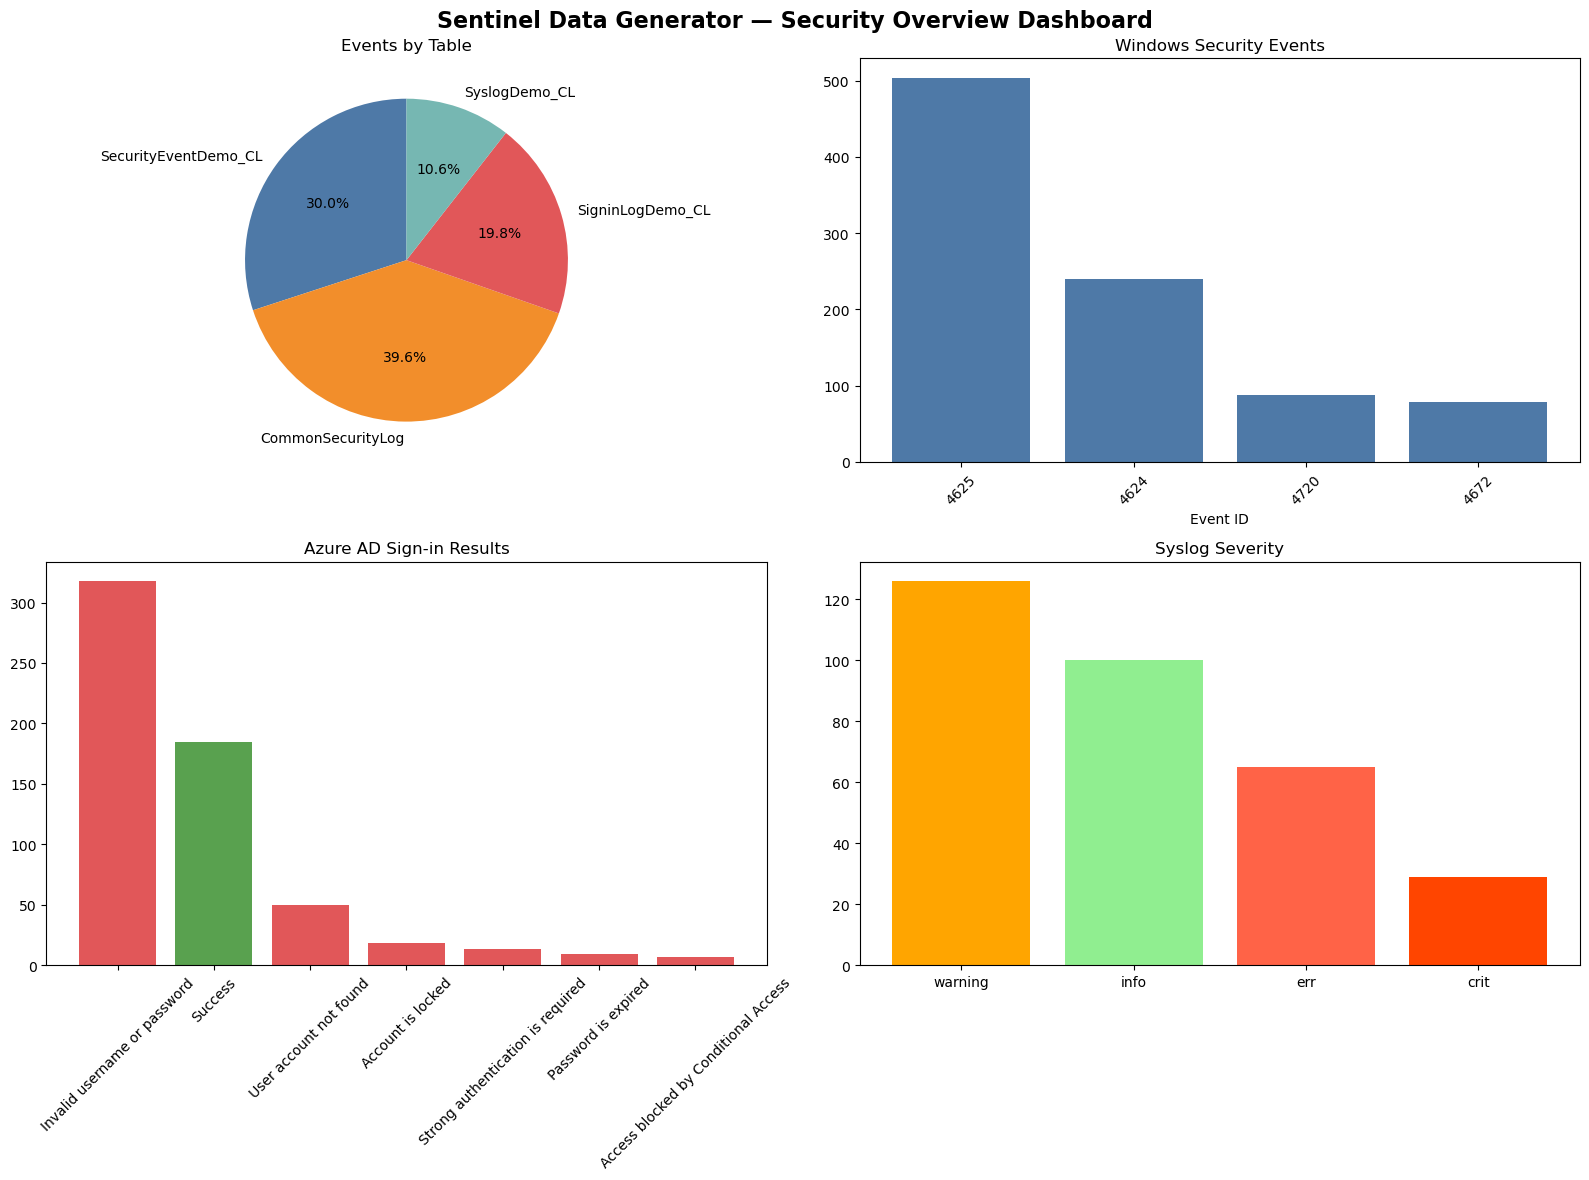

In [27]:
# Create a 2x2 summary dashboard
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Sentinel Data Generator — Security Overview Dashboard", fontsize=16, fontweight="bold")

# Plot 1: Events by table (pie)
axes[0, 0].pie(
    counts.values(),
    labels=counts.keys(),
    autopct="%1.1f%%",
    startangle=90,
    colors=["#4e79a7", "#f28e2b", "#e15759", "#76b7b2"]
)
axes[0, 0].set_title("Events by Table")

# Plot 2: Security events by EventID (bar)
axes[0, 1].bar(pd_security["EventID"].astype(str), pd_security["Count"], color="#4e79a7")
axes[0, 1].set_title("Windows Security Events")
axes[0, 1].set_xlabel("Event ID")
axes[0, 1].tick_params(axis="x", rotation=45)

# Plot 3: Sign-in results (bar)
signin_colors = ["#59a14f" if rt == "0" else "#e15759" for rt in pd_signin["ResultType"]]
axes[1, 0].bar(pd_signin["ResultDescription"], pd_signin["Count"], color=signin_colors)
axes[1, 0].set_title("Azure AD Sign-in Results")
axes[1, 0].tick_params(axis="x", rotation=45)

# Plot 4: Syslog severity (bar)
sev_colors = [severity_colors.get(s, "#CCCCCC") for s in syslog_by_severity.index]
axes[1, 1].bar(syslog_by_severity.index, syslog_by_severity.values, color=sev_colors)
axes[1, 1].set_title("Syslog Severity")

plt.tight_layout()
plt.show()

## 8. Key Findings Summary

In [28]:
# Collect summary counts from Spark DataFrames
failed_4625_count = df_security_events.filter(col("EventID") == 4625).count()
brute_force_sources = failed_logins.count()

success_signin_count = df_signin_logs.filter(col("ResultType") == "0").count()
failed_signin_count = df_signin_logs.filter(col("ResultType") != "0").count()
risky_count = risky_signins.count()

threat_count = threats.count()
firewall_count = firewall_denies.count()

ssh_target_count = ssh_failures.count()
service_failure_count = service_failures.count()

print("=" * 60)
print("SECURITY ANALYSIS SUMMARY")
print("=" * 60)
print(f"\nTotal Events Analyzed: {total:,}")
print(f"\nWindows Security:")
print(f"  - Failed Logons (4625): {failed_4625_count:,}")
print(f"  - Potential Brute Force Sources: {brute_force_sources}")
print(f"\nAzure AD Sign-ins:")
print(f"  - Successful: {success_signin_count:,}")
print(f"  - Failed: {failed_signin_count:,}")
print(f"  - Risky Sign-ins: {risky_count}")
print(f"\nNetwork Security (CommonSecurityLog):")
print(f"  - Threat Detections: {threat_count}")
print(f"  - Firewall Blocks: {firewall_count}")
print(f"\nLinux Systems (Syslog):")
print(f"  - SSH Attack Targets: {ssh_target_count}")
print(f"  - Service Failures: {service_failure_count}")
print("\n" + "=" * 60)

StatementMeta(MSGMedium, 2, 29, Finished, Available, Finished)

SECURITY ANALYSIS SUMMARY

Total Events Analyzed: 3,031

Windows Security:
  - Failed Logons (4625): 504
  - Potential Brute Force Sources: 1

Azure AD Sign-ins:
  - Successful: 185
  - Failed: 415
  - Risky Sign-ins: 15

Network Security (CommonSecurityLog):
  - Threat Detections: 15
  - Firewall Blocks: 0

Linux Systems (Syslog):
  - SSH Attack Targets: 12
  - Service Failures: 15



# Sentinel Data Generator - Log Analysis

This notebook analyzes the demo security data generated by the Sentinel Data Generator project.

**Tables Analyzed:**
- `SecurityEventDemo_CL` - Windows Security Events
- `CommonSecurityLog` - CEF/Syslog from security appliances
- `SigninLogDemo_CL` - Azure AD/Entra ID Sign-in Logs
- `SyslogDemo_CL` - Linux Syslog Events

**Requirements:** Run this notebook in Microsoft Sentinel with compute enabled.

## 1. Setup and Authentication

Connect to the Log Analytics workspace using msticpy (pre-installed in Sentinel compute).

In [ ]:
# Install plotly for visualizations (msticpy is pre-installed in Sentinel)
%pip install plotly kaleido --quiet

StatementMeta(, 0, 8, Cancelled, , Cancelled)

: 

: 

StatementMeta(MSGMedium, 2, 33, Submitted, Running, Running)

In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from datetime import datetime, timedelta

# msticpy is pre-installed in Sentinel compute
from msticpy.data import QueryProvider

print("Libraries loaded successfully")

In [ ]:
# Initialize the Log Analytics query provider
# In Sentinel compute, authentication is handled automatically
qry_prov = QueryProvider("LogAnalytics")

# Connect - this will use the workspace context from Sentinel
qry_prov.connect()

print("Connected to Log Analytics workspace")

In [ ]:
def run_query(query: str) -> pd.DataFrame:
    """Execute a KQL query and return results as a DataFrame."""
    return qry_prov.exec_query(query)

print("Query helper function ready")

## 2. Overview - All Tables Summary

In [ ]:
# Get event counts from all 4 tables
overview_query = """
union 
  (SecurityEventDemo_CL | summarize Count=count() | extend Table="SecurityEventDemo_CL"),
  (SigninLogDemo_CL | summarize Count=count() | extend Table="SigninLogDemo_CL"),
  (SyslogDemo_CL | summarize Count=count() | extend Table="SyslogDemo_CL"),
  (CommonSecurityLog | summarize Count=count() | extend Table="CommonSecurityLog")
| project Table, Count
| order by Count desc
"""

df_overview = run_query(overview_query)
df_overview

In [ ]:
# Visualize table distribution
fig = px.pie(
    df_overview, 
    values='Count', 
    names='Table',
    title='Event Distribution by Table',
    color_discrete_sequence=px.colors.qualitative.Set2
)
fig.update_traces(textposition='inside', textinfo='percent+label+value')
fig.show()

## 3. SecurityEventDemo_CL Analysis

Windows Security Events including failed/successful logons, privilege escalation, and account management.

In [ ]:
# Security events by EventID
security_events_query = """
SecurityEventDemo_CL
| summarize Count=count() by EventID, Activity
| order by Count desc
"""

df_security = run_query(security_events_query)
df_security

In [ ]:
# Security events over time
security_timeline_query = """
SecurityEventDemo_CL
| summarize Count=count() by bin(TimeGenerated, 1h), EventID
| order by TimeGenerated asc
"""

df_security_time = run_query(security_timeline_query)

fig = px.bar(
    df_security, 
    x='EventID', 
    y='Count',
    color='Activity',
    title='Windows Security Events by Event ID',
    text='Count'
)
fig.update_traces(textposition='outside')
fig.show()

In [ ]:
# Failed logins analysis (brute force detection)
failed_logins_query = """
SecurityEventDemo_CL
| where EventID == 4625
| summarize FailedAttempts=count() by IpAddress, Account, Computer
| where FailedAttempts >= 5
| order by FailedAttempts desc
| take 20
"""

df_failed = run_query(failed_logins_query)
print("Potential Brute Force Sources (5+ failed logins):")
df_failed

In [ ]:
if not df_failed.empty:
    fig = px.bar(
        df_failed.head(10), 
        x='IpAddress', 
        y='FailedAttempts',
        color='Account',
        title='Top Failed Login Sources (Potential Brute Force)',
        text='FailedAttempts'
    )
    fig.show()

## 4. CommonSecurityLog Analysis

CEF events from security appliances including firewall, IDS, and threat intelligence.

In [ ]:
# Events by vendor and event class
cef_vendor_query = """
CommonSecurityLog
| summarize Count=count() by DeviceVendor, DeviceEventClassID
| order by Count desc
| take 20
"""

df_cef = run_query(cef_vendor_query)
df_cef

In [ ]:
fig = px.treemap(
    df_cef, 
    path=['DeviceVendor', 'DeviceEventClassID'], 
    values='Count',
    title='CommonSecurityLog Events by Vendor and Event Type',
    color='Count',
    color_continuous_scale='RdYlGn_r'
)
fig.show()

In [ ]:
# Threat intelligence and intrusion detections
threats_query = """
CommonSecurityLog
| where DeviceEventClassID in ("threat:match", "intrusion:detected", "malware:detected")
| summarize Count=count() by DeviceVendor, DeviceEventClassID, SourceIP
| order by Count desc
| take 15
"""

df_threats = run_query(threats_query)
print("Security Threats Detected:")
df_threats

In [ ]:
# Firewall denies by source IP
firewall_query = """
CommonSecurityLog
| where DeviceEventClassID == "traffic:deny"
| summarize DenyCount=count() by SourceIP, DestinationIP
| where DenyCount >= 5
| order by DenyCount desc
| take 15
"""

df_firewall = run_query(firewall_query)
print("Firewall Blocks (5+ denies):")
df_firewall

## 5. SigninLogDemo_CL Analysis

Azure AD/Entra ID sign-in events including brute force and credential stuffing attacks.

In [ ]:
# Sign-in results overview
signin_results_query = """
SigninLogDemo_CL
| summarize Count=count() by ResultType, ResultDescription
| order by Count desc
"""

df_signin = run_query(signin_results_query)
df_signin

In [ ]:
# Visualize sign-in results
fig = px.bar(
    df_signin, 
    x='ResultDescription', 
    y='Count',
    color='ResultType',
    title='Azure AD Sign-in Results',
    text='Count'
)
fig.update_layout(xaxis_tickangle=-45)
fig.show()

In [ ]:
# Risky sign-ins
risky_signin_query = """
SigninLogDemo_CL
| where RiskLevelDuringSignIn in ("medium", "high")
| summarize Count=count() by UserPrincipalName, IPAddress, Location, RiskLevelDuringSignIn
| order by Count desc
| take 15
"""

df_risky = run_query(risky_signin_query)
print("Risky Sign-ins Detected:")
df_risky

In [ ]:
# Sign-ins by location
signin_location_query = """
SigninLogDemo_CL
| summarize Count=count(), 
            Success=countif(ResultType == "0"), 
            Failed=countif(ResultType != "0") 
  by Location
| extend FailureRate = round(100.0 * Failed / Count, 1)
| order by Count desc
"""

df_location = run_query(signin_location_query)
df_location

In [ ]:
fig = px.bar(
    df_location, 
    x='Location', 
    y=['Success', 'Failed'],
    title='Sign-in Attempts by Location',
    barmode='stack',
    color_discrete_map={'Success': 'green', 'Failed': 'red'}
)
fig.show()

## 6. SyslogDemo_CL Analysis

Linux syslog events including SSH authentication, sudo abuse, and service failures.

In [ ]:
# Syslog by facility and severity
syslog_overview_query = """
SyslogDemo_CL
| summarize Count=count() by Facility, SeverityLevel
| order by Count desc
"""

df_syslog = run_query(syslog_overview_query)
df_syslog

In [ ]:
fig = px.sunburst(
    df_syslog, 
    path=['Facility', 'SeverityLevel'], 
    values='Count',
    title='Syslog Events by Facility and Severity',
    color='SeverityLevel',
    color_discrete_map={
        'emerg': '#8B0000', 'alert': '#FF0000', 'crit': '#FF4500',
        'err': '#FF6347', 'warning': '#FFA500', 'notice': '#FFD700',
        'info': '#90EE90', 'debug': '#ADD8E6'
    }
)
fig.show()

In [ ]:
# SSH authentication failures
ssh_failures_query = """
SyslogDemo_CL
| where ProcessName == "sshd" and SyslogMessage has "Failed"
| summarize FailedAttempts=count() by Computer, HostIP
| where FailedAttempts >= 3
| order by FailedAttempts desc
| take 15
"""

df_ssh = run_query(ssh_failures_query)
print("SSH Brute Force Targets (3+ failures):")
df_ssh

In [ ]:
# Service failures
service_failures_query = """
SyslogDemo_CL
| where Facility == "daemon" and SeverityLevel in ("err", "crit")
| summarize Count=count() by Computer, ProcessName, SeverityLevel
| order by Count desc
| take 15
"""

df_services = run_query(service_failures_query)
print("Service Failures:")
df_services

## 7. Security Summary Dashboard

In [ ]:
# Create a comprehensive dashboard
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Events by Table', 
        'Windows Security Events',
        'Sign-in Results', 
        'Syslog Severity'
    ),
    specs=[
        [{"type": "pie"}, {"type": "bar"}],
        [{"type": "bar"}, {"type": "bar"}]
    ]
)

# Plot 1: Events by table
fig.add_trace(
    go.Pie(labels=df_overview['Table'], values=df_overview['Count'], name="Tables"),
    row=1, col=1
)

# Plot 2: Security Events
fig.add_trace(
    go.Bar(x=df_security['EventID'].astype(str), y=df_security['Count'], name="Security Events"),
    row=1, col=2
)

# Plot 3: Sign-in Results
fig.add_trace(
    go.Bar(x=df_signin['ResultDescription'], y=df_signin['Count'], name="Sign-ins"),
    row=2, col=1
)

# Plot 4: Syslog Severity
syslog_severity = df_syslog.groupby('SeverityLevel')['Count'].sum().reset_index()
fig.add_trace(
    go.Bar(x=syslog_severity['SeverityLevel'], y=syslog_severity['Count'], name="Syslog"),
    row=2, col=2
)

fig.update_layout(
    height=800, 
    title_text="Sentinel Data Generator - Security Overview Dashboard",
    showlegend=False
)
fig.show()

## 8. Key Findings Summary

In [ ]:
# Generate summary statistics
total_events = df_overview['Count'].sum()
failed_logins_count = df_security[df_security['EventID'] == 4625]['Count'].sum() if not df_security.empty else 0
success_signins = df_signin[df_signin['ResultType'] == '0']['Count'].sum() if not df_signin.empty else 0
failed_signins = df_signin[df_signin['ResultType'] != '0']['Count'].sum() if not df_signin.empty else 0

print("="*60)
print("SECURITY ANALYSIS SUMMARY")
print("="*60)
print(f"\nTotal Events Analyzed: {total_events:,}")
print(f"\nWindows Security:")
print(f"  - Failed Logons (4625): {failed_logins_count:,}")
print(f"  - Potential Brute Force Sources: {len(df_failed)}")
print(f"\nAzure AD Sign-ins:")
print(f"  - Successful: {success_signins:,}")
print(f"  - Failed: {failed_signins:,}")
print(f"  - Risky Sign-ins: {len(df_risky)}")
print(f"\nNetwork Security (CommonSecurityLog):")
print(f"  - Threat Detections: {len(df_threats)}")
print(f"  - Firewall Blocks: {len(df_firewall)}")
print(f"\nLinux Systems (Syslog):")
print(f"  - SSH Attack Targets: {len(df_ssh)}")
print(f"  - Service Failures: {len(df_services)}")
print("\n" + "="*60)